This notebook follows the same procedure as *feature_engineering_PCA.ipynb* except here we don't drop te highly correlated features.

In [19]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [20]:
# import data
X_train_original = pd.read_pickle('data/X_train_scaled.pkl')
X_test_original = pd.read_pickle('data/X_test_scaled.pkl')
y_train_common = pd.read_pickle('data/y_train_common.pkl')
y_train_motor = pd.read_pickle('data/y_train_motor.pkl')
y_train_total = pd.read_pickle('data/y_train_total.pkl')
y_test_common = pd.read_pickle('data/y_test_common.pkl')
y_test_motor = pd.read_pickle('data/y_test_motor.pkl')
y_test_total = pd.read_pickle('data/y_test_total.pkl')

In [21]:
X_train_original.corr().style.background_gradient(cmap='coolwarm', axis=None)

,sex,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,RPDE,DFA,PPE,age,test_time,Shimmer(dB),HNR
sex,1.000000,-0.084545,-0.331988,-0.001288,-0.065506,-0.001317,-0.033728,-0.038342,-0.038049,-0.051639,-0.038342,0.067584,-0.238216,-0.050419,-0.154295,-0.100677,0.009942,-0.039083,0.067409
Jitter(%),-0.084545,1.000000,0.891296,0.963768,0.957579,0.963771,0.498357,0.476705,0.466179,0.467512,0.476704,0.549152,0.506626,0.431659,0.830235,0.087398,-0.014423,0.520798,-0.678408
Jitter(Abs),-0.331988,0.891296,1.000000,0.828632,0.858473,0.828624,0.459629,0.426369,0.436997,0.449427,0.426366,0.516541,0.602437,0.448604,0.789889,0.048773,-0.024843,0.472834,-0.661123
Jitter:RAP,-0.001288,0.963768,0.828632,1.000000,0.944268,0.999998,0.496728,0.493052,0.463553,0.442974,0.493052,0.513265,0.426274,0.426644,0.756627,0.070785,-0.022139,0.509374,-0.647777
Jitter:PPQ5,-0.065506,0.957579,0.858473,0.944268,1.000000,0.944281,0.549604,0.523030,0.524270,0.517211,0.523029,0.567766,0.481178,0.438986,0.820566,0.087376,-0.019241,0.566697,-0.708943
Jitter:DDP,-0.001317,0.963771,0.828624,0.999998,0.944281,1.000000,0.496747,0.493066,0.463570,0.442995,0.493066,0.513272,0.426252,0.426667,0.756636,0.070791,-0.022119,0.509392,-0.647804
Shimmer,-0.033728,0.498357,0.459629,0.496728,0.549604,0.496747,1.000000,0.977262,0.987403,0.944512,0.977261,0.678809,0.423427,0.149441,0.498878,0.178383,-0.037963,0.989462,-0.737086
Shimmer:APQ3,-0.038342,0.476705,0.426369,0.493052,0.523030,0.493066,0.977262,1.000000,0.968280,0.885157,1.000000,0.588940,0.380717,0.144216,0.462400,0.167213,-0.036022,0.960731,-0.711559
Shimmer:APQ5,-0.038049,0.466179,0.436997,0.463553,0.524270,0.463570,0.987403,0.968280,1.000000,0.950032,0.968279,0.657841,0.407816,0.156113,0.480433,0.165850,-0.040595,0.976666,-0.730563
Shimmer:APQ11,-0.051639,0.467512,0.449427,0.442974,0.517211,0.442995,0.944512,0.885157,0.950032,1.000000,0.885154,0.655592,0.435947,0.172936,0.512121,0.204670,-0.038950,0.942951,-0.723131


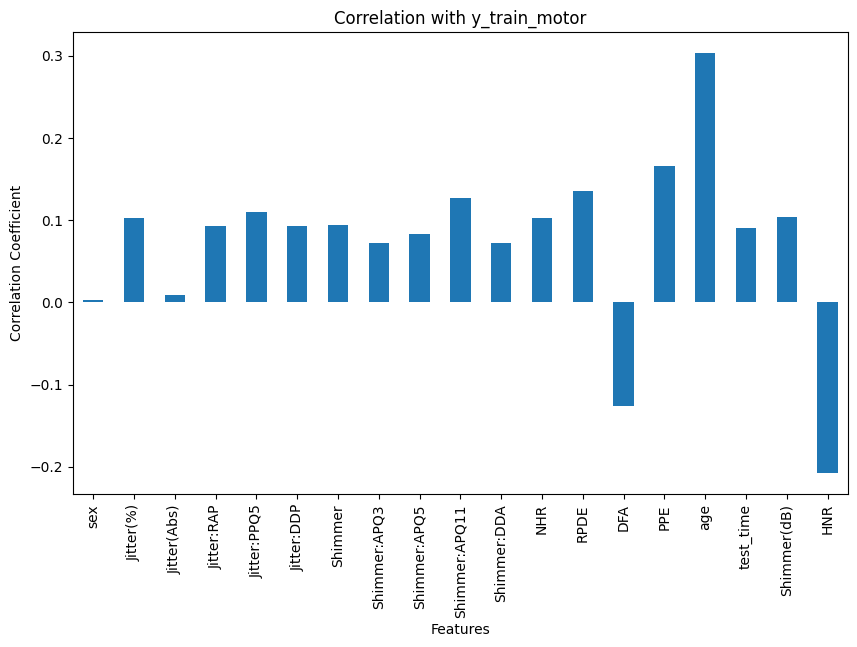

In [22]:
def plot_correlation_with_target(X_train, y_train, target_name):
    correlation = X_train.corrwith(y_train)
    plt.figure(figsize=(10, 6))
    correlation.plot(kind='bar')
    plt.title(f'Correlation with {target_name}')
    plt.xlabel('Features')
    plt.ylabel('Correlation Coefficient')
    plt.show()

plot_correlation_with_target(X_train_original, y_train_motor, 'y_train_motor')

Skewness:
 NHR              6.454374
Shimmer:APQ11    3.069720
Shimmer:APQ5     2.865452
Shimmer          2.768091
Shimmer:DDA      2.748309
Shimmer:APQ3     2.748257
Shimmer(dB)      2.640879
Jitter:PPQ5      1.663037
Jitter(Abs)      1.484635
Jitter:DDP       1.427376
Jitter:RAP       1.427367
Jitter(%)        1.338358
sex              0.766406
PPE              0.655141
DFA              0.136657
test_time        0.084418
RPDE            -0.136813
age             -0.143822
HNR             -0.178031
dtype: float64


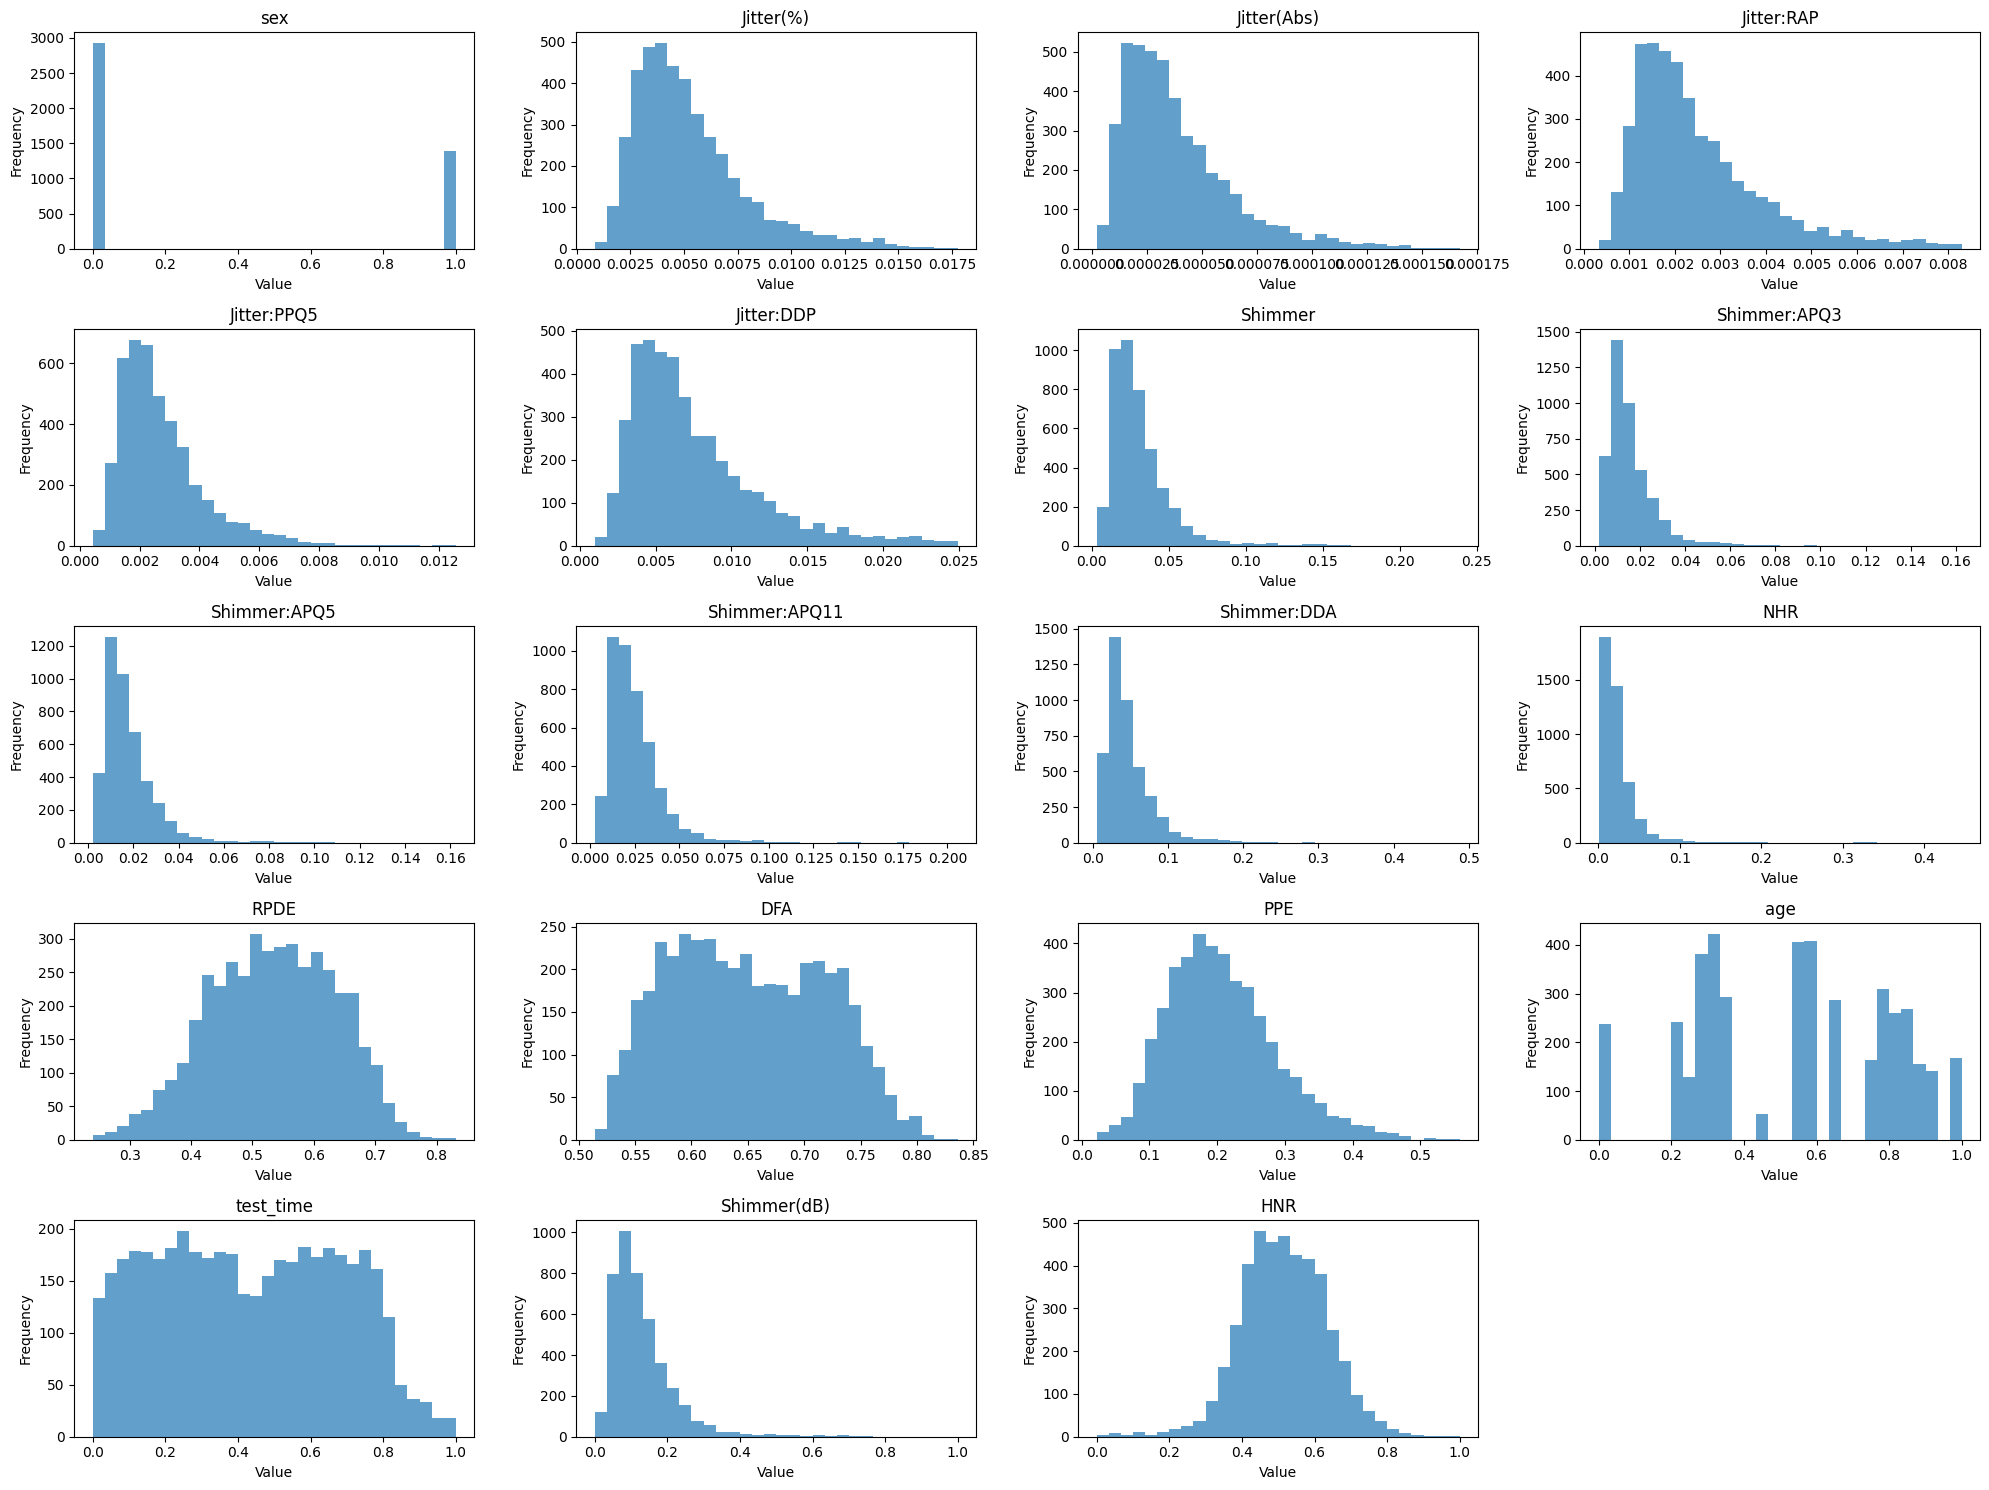

In [23]:
def plot_feature_distributions(X_train):
    skewness = X_train.skew()
    print("Skewness:\n", skewness.sort_values(ascending=False))

    plt.figure(figsize=(20, 15))
    for i, column in enumerate(X_train.columns):
        plt.subplot(5, 4, i + 1)
        plt.hist(X_train[column], bins=30, alpha=0.7)
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_feature_distributions(X_train_original)

We see that there are some features that are skewed so we apply Yeo-Johnson transformation to make the data less skewed.

In [24]:
def apply_power_transformer(X_train, X_test):
    pt = PowerTransformer()
    X_train_transformed = pt.fit_transform(X_train)
    X_test_transformed = pt.transform(X_test)
    return pd.DataFrame(X_train_transformed, columns=X_train.columns), pd.DataFrame(X_test_transformed, columns=X_test.columns)

X_train_transformed, X_test_transformed = apply_power_transformer(X_train_original, X_test_original)

Skewness:
 sex              0.766406
NHR              0.314490
Shimmer:APQ3     0.175277
Jitter:RAP       0.171979
Jitter:DDP       0.170544
Shimmer:APQ5     0.170039
Jitter(Abs)      0.164414
Shimmer:DDA      0.163959
Shimmer          0.155928
Shimmer:APQ11    0.135351
Jitter:PPQ5      0.126412
Shimmer(dB)      0.121618
Jitter(%)        0.117930
HNR              0.030201
DFA              0.014942
PPE              0.012245
RPDE            -0.024223
test_time       -0.032254
age             -0.084911
dtype: float64


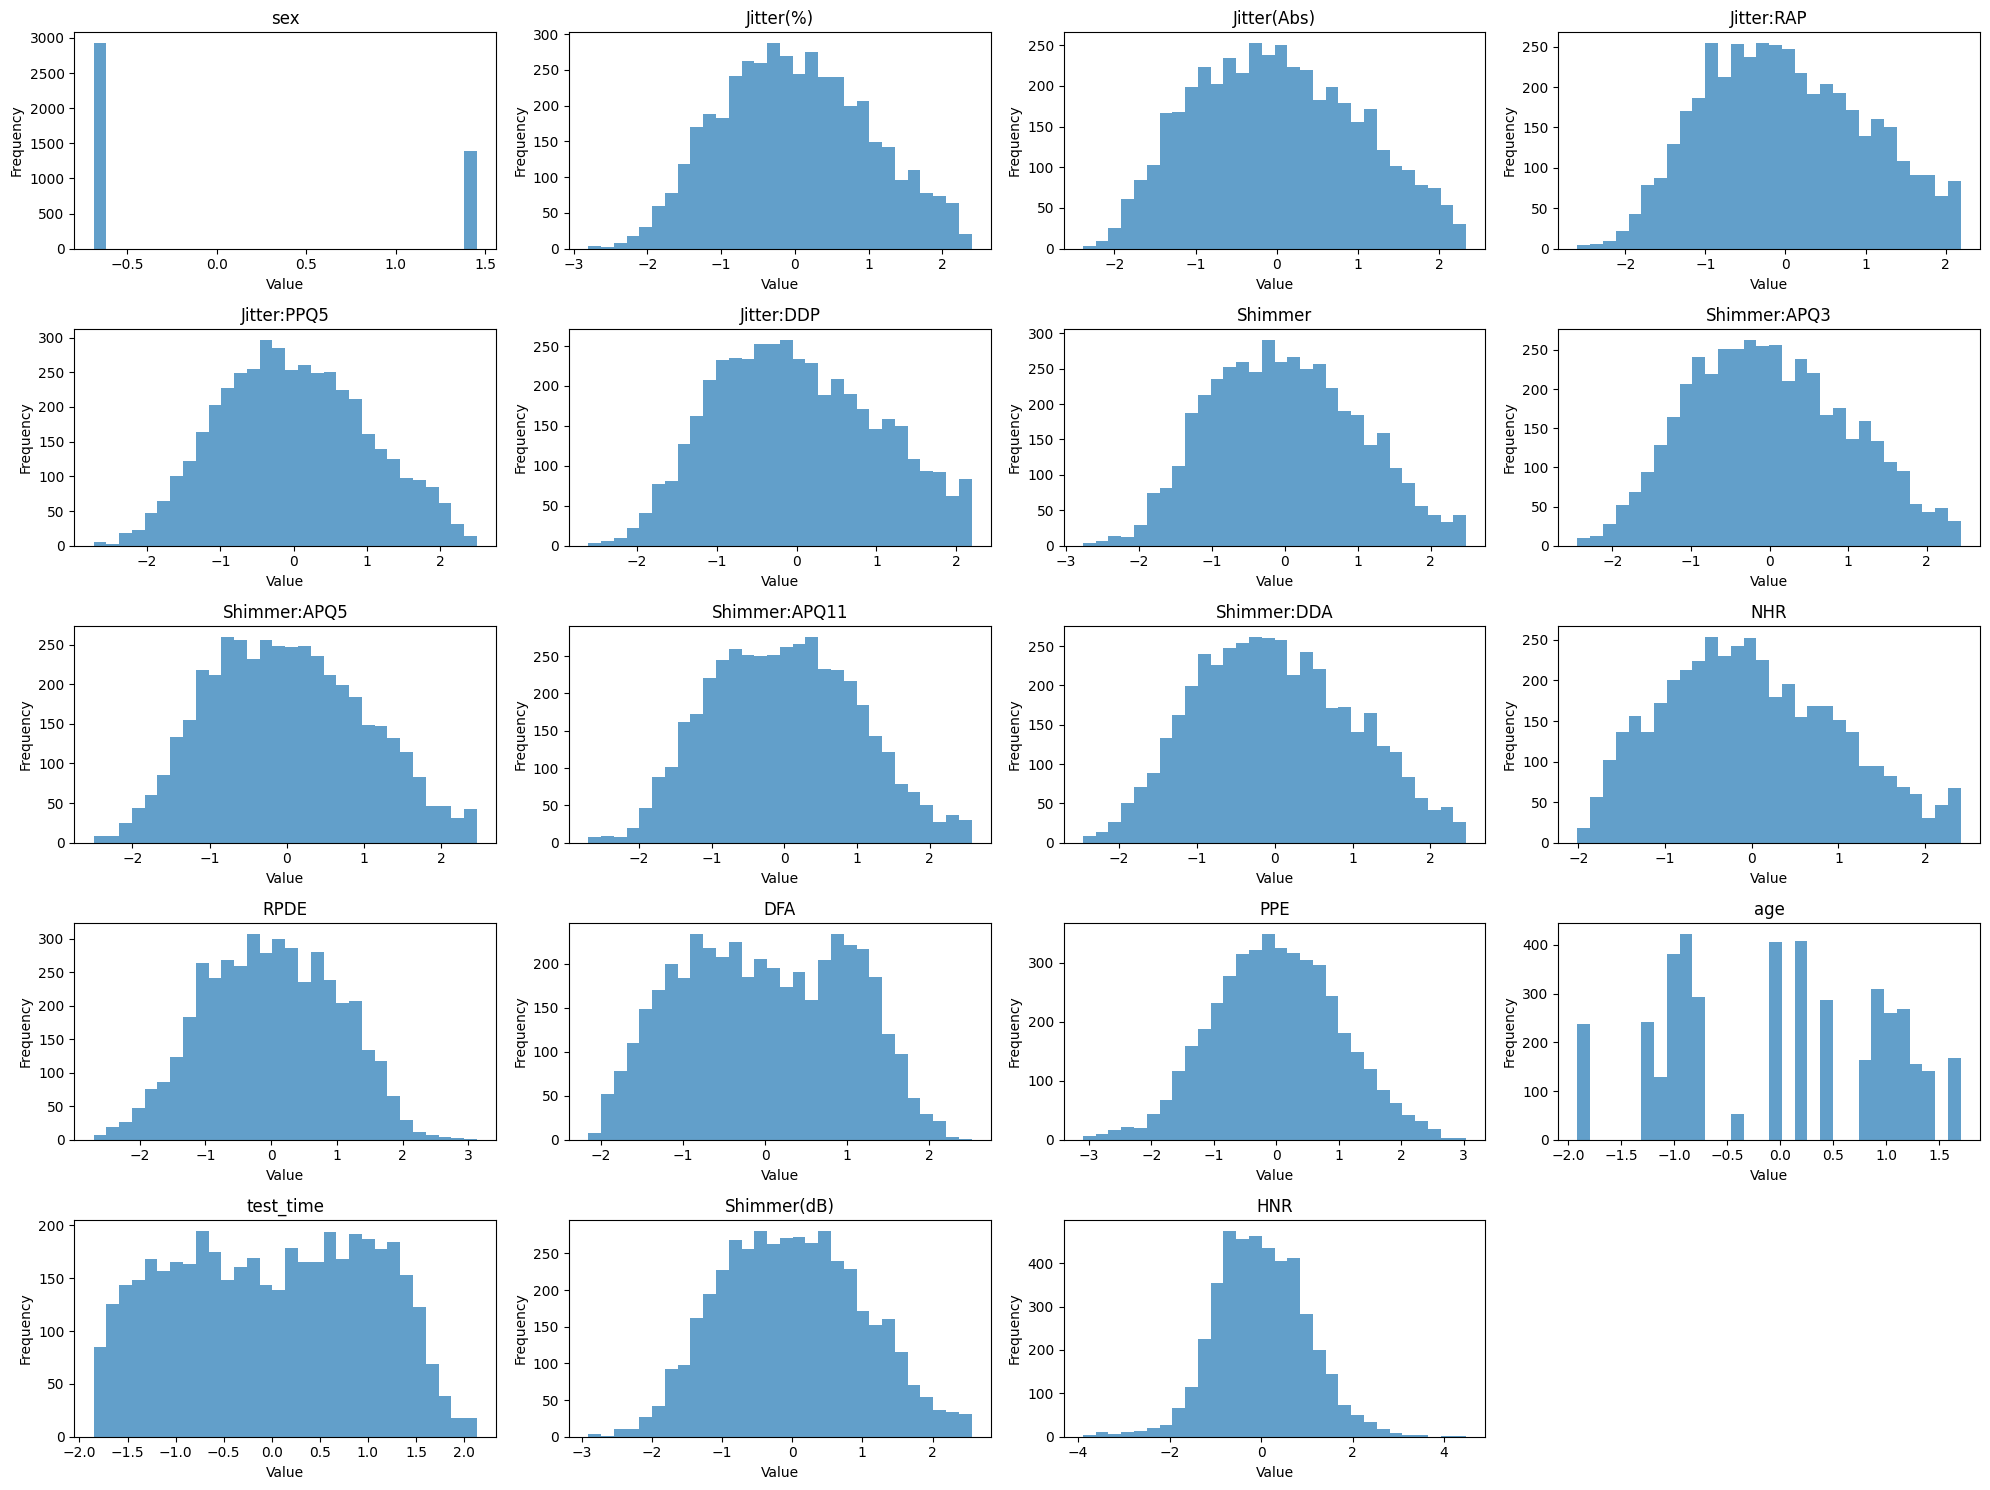

In [25]:
plot_feature_distributions(X_train_transformed)

## Principal Component Analysis

We try PCA to reduce the dimensionality of the data

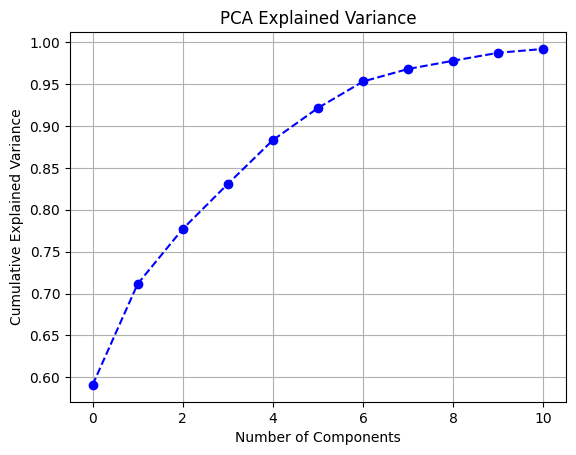

In [26]:
pca = PCA(n_components=0.99)
pca.fit(X_train_transformed)

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', ls='--', color='blue')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

After 5 components we can explain 99% of the variance. Let's use 5 components for PCA.

In [27]:
pca = PCA(5)
X_train_pca = pca.fit_transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)

X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

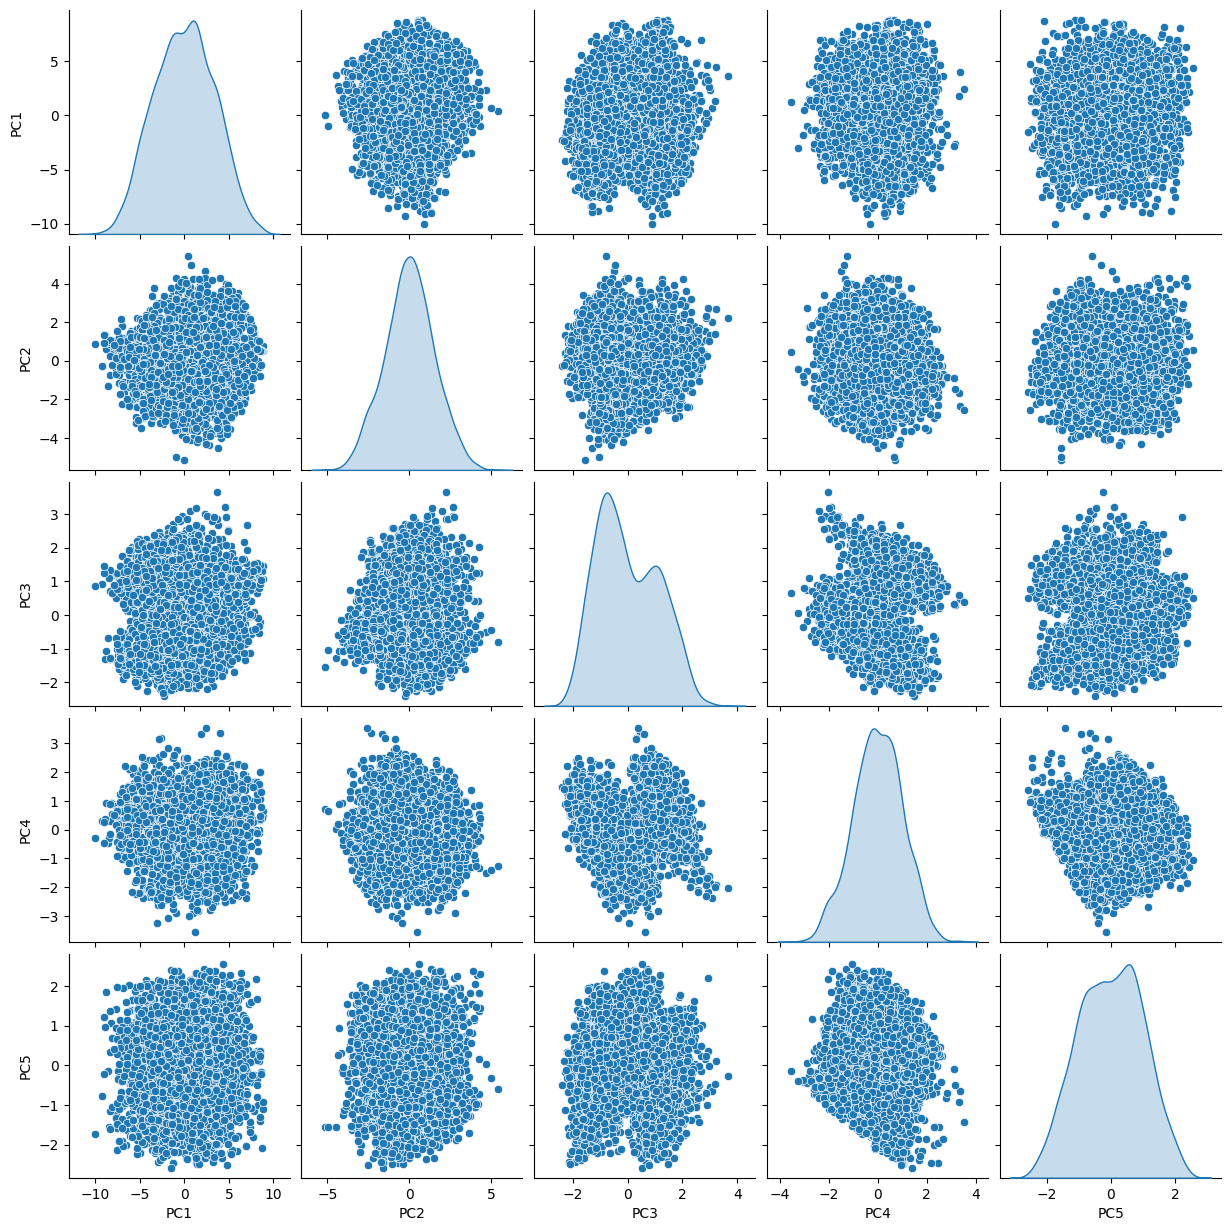

In [28]:
sns.pairplot(X_train_pca, diag_kind='kde', markers='o')

We see some clustering in the PCA space, which indicates that the features are not completely independent. This is expected as the original features were correlated. However, PCA has reduced the dimensionality while retaining most of the variance in the data.

In [29]:
X_train_pca.corr().style.background_gradient(cmap='coolwarm', axis=None)

,PC1,PC2,PC3,PC4,PC5
PC1,1.000000,-0.000000,-0.000000,0.000000,-0.000000
PC2,-0.000000,1.000000,0.000000,-0.000000,-0.000000
PC3,-0.000000,0.000000,1.000000,0.000000,-0.000000
PC4,0.000000,-0.000000,0.000000,1.000000,-0.000000
PC5,-0.000000,-0.000000,-0.000000,-0.000000,1.000000


We overcome the multicollinearity problem by using PCA. The PCA components are uncorrelated and can be used as features in the model. 

In [30]:
X_train_pca.skew().sort_values(ascending=False)

PC3    0.303738
PC2   -0.001177
PC1   -0.005148
PC5   -0.050202
PC4   -0.082608
dtype: float64

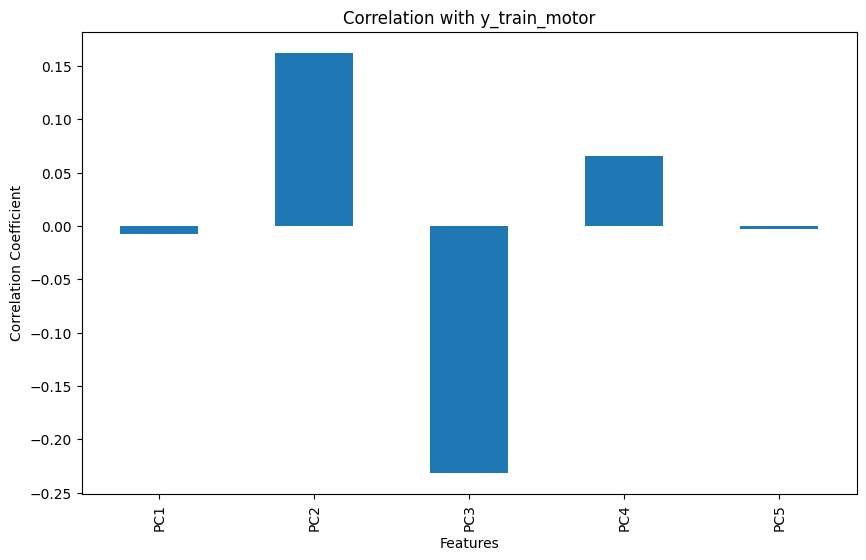

In [31]:
plot_correlation_with_target(X_train_pca, y_train_motor, 'y_train_motor')

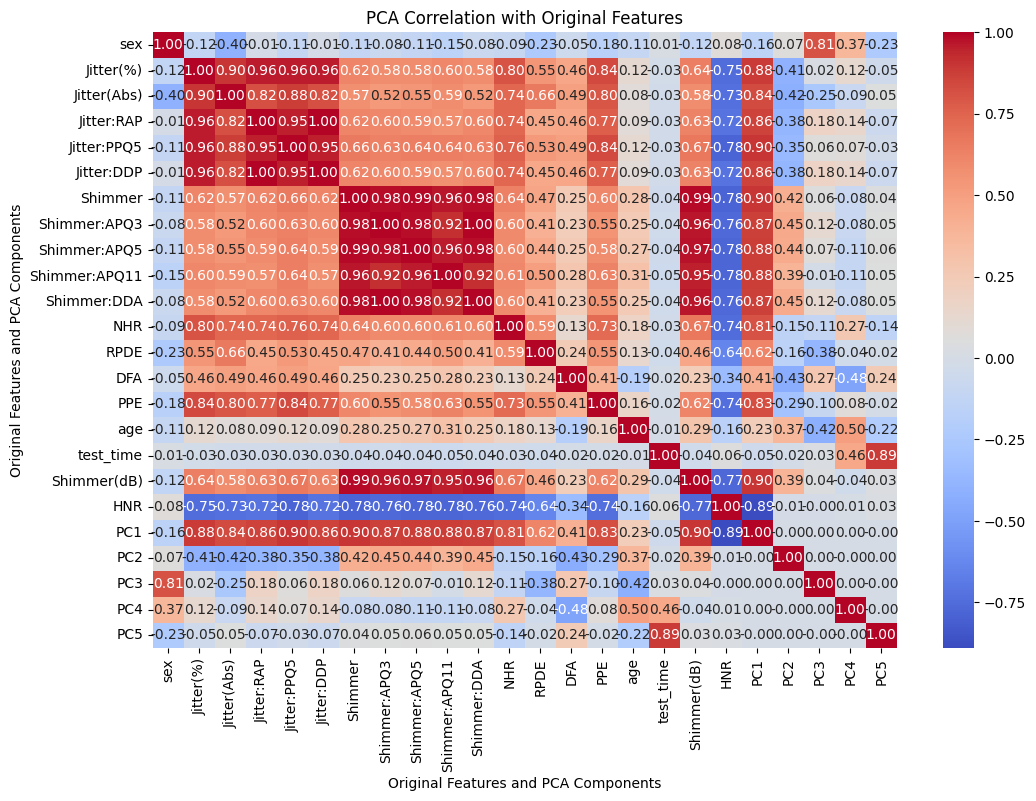

In [32]:
pca_corr = np.corrcoef(X_train_transformed.T, X_train_pca.T)

feature_names = list(X_train_transformed.columns)

n_components = pca.n_components_
all_ticks = feature_names + [f'PC{i+1}' for i in range(n_components)]

plt.figure(figsize=(12, 8))
import seaborn as sns
sns.heatmap(pca_corr, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=all_ticks, yticklabels=all_ticks)
plt.title('PCA Correlation with Original Features')
plt.xlabel('Original Features and PCA Components')
plt.ylabel('Original Features and PCA Components')
plt.show()

This shows the correlation between the original features and the PCA components. 

In [33]:
# we combine PCA features with original features
X_train_combined = pd.concat([X_train_transformed, X_train_pca], axis=1)
X_test_combined = pd.concat([X_test_transformed, X_test_pca], axis=1)

In [34]:
# check performance with linear regression
lr = LinearRegression()
lr.fit(X_train_combined, y_train_motor)
y_train_pred = lr.predict(X_train_combined)
y_test_pred = lr.predict(X_test_combined)

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

mae_train, mse_train, rmse_train, r2_train = evaluate_model(y_train_motor, y_train_pred)
mae_test, mse_test, rmse_test, r2_test = evaluate_model(y_test_motor, y_test_pred)

print(f"Train MAE: {mae_train}, Train MSE: {mse_train}, Train RMSE: {rmse_train}, Train R2: {r2_train}")
print(f"Test MAE: {mae_test}, Test MSE: {mse_test}, Test RMSE: {rmse_test}, Test R2: {r2_test}")

Train MAE: 6.319856638265963, Train MSE: 56.33220630399428, Train RMSE: 7.505478419394348, Train R2: 0.23982218635759311
Test MAE: 6.617322800464734, Test MSE: 54.003397302615866, Test RMSE: 7.348700381878136, Test R2: -0.680430695659688


In [35]:
# check performance with Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_combined, y_train_motor)
y_train_pred_rf = rf.predict(X_train_combined)
y_test_pred_rf = rf.predict(X_test_combined)

mae_train_rf, mse_train_rf, rmse_train_rf, r2_train_rf = evaluate_model(y_train_motor, y_train_pred_rf)
mae_test_rf, mse_test_rf, rmse_test_rf, r2_test_rf = evaluate_model(y_test_motor, y_test_pred_rf)

print(f"Random Forest Train MAE: {mae_train_rf}, Train MSE: {mse_train_rf}, Train RMSE: {rmse_train_rf}, Train R2: {r2_train_rf}")
print(f"Random Forest Test MAE: {mae_test_rf}, Test MSE: {mse_test_rf}, Test RMSE: {rmse_test_rf}, Test R2: {r2_test_rf}")

Random Forest Train MAE: 0.22858833572586312, Train MSE: 0.32679066147193625, Train RMSE: 0.5716560692163919, Train R2: 0.9955901068526252
Random Forest Test MAE: 6.512256464811782, Test MSE: 57.900973196236286, Test RMSE: 7.609268900245035, Test R2: -0.8017120686370456


Adding PCA as features didn't improve the model performance.